In [1]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
import tensorflow as tf
import textgenrnn

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


# Overview
- Intro about machine learning and education 
    - Examples, fears, hopes
- Simple Linear Regression
    - 2d Boston
        - Look at scatter plot of RM and MEDV
        - How do we fit a line?
        - How do we know the best fit?
        - How do we optimize?
    - 3d Boston
        - Same stuff
    - More d Boston
        - Same stuff
        - Requires understanding statistics
- Logistic Regression
    - MNIST: Lots of data
    - How does logistic regression work?
    - How do we feed in an image?
- Simple NN with MNIST
- CNN with MNIST
- Conclusion
    

In [3]:
boston_dataset = load_boston()

In [19]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [92]:
boston_df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_df['MEDV'] = boston_dataset.target

In [93]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [94]:
# X = pd.DataFrame(np.c_[boston_df['LSTAT'], boston_df['RM'], boston_df['CRIM'], boston_df['ZN'], boston_df['INDUS'], boston_df['CHAS'], boston_df['NOX'], boston_df['AGE'], boston_df['DIS'], boston_df['RAD'], boston_df['TAX'], boston_df['PTRATIO'], boston_df['B']], columns = ['LSTAT','RM', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B'])
# X = pd.DataFrame(np.c_[boston_df['LSTAT'], boston_df['RM']], columns=['LSTAT', 'RM'])
X = pd.DataFrame(boston_df['RM'], columns=['RM'])
Y = boston_df['MEDV']

In [95]:
only_rooms_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['MEDV']], columns=['RM', 'MEDV'])

# What is Machine Learning?

# What is Machine Learning?
## Consider the familiar example -- RM is average number of rooms, MEDV is median value in $1000s
## We will try to predict the value of a home from the number of rooms.

In [96]:
only_rooms_df.head(10)

,RM,MEDV
0,6.575,24.0
1,6.421,21.6
2,7.185,34.7
3,6.998,33.4
4,7.147,36.2
5,6.430,28.7
6,6.012,22.9
7,6.172,27.1
8,5.631,16.5
9,6.004,18.9


# Does there seem to be any correlation between number of rooms and price?

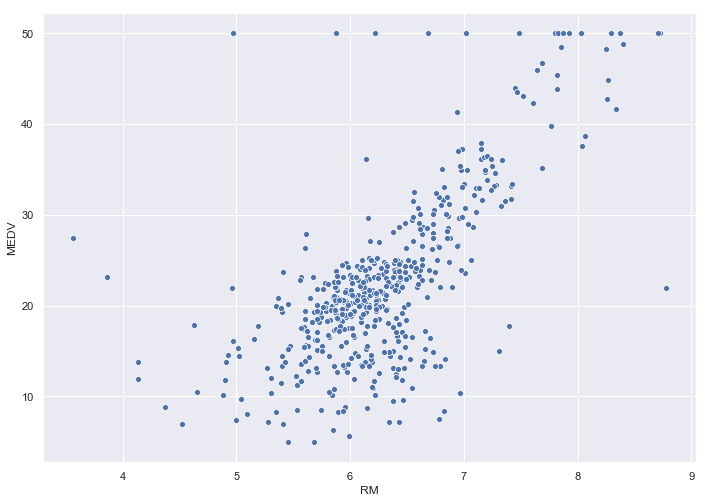

In [10]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

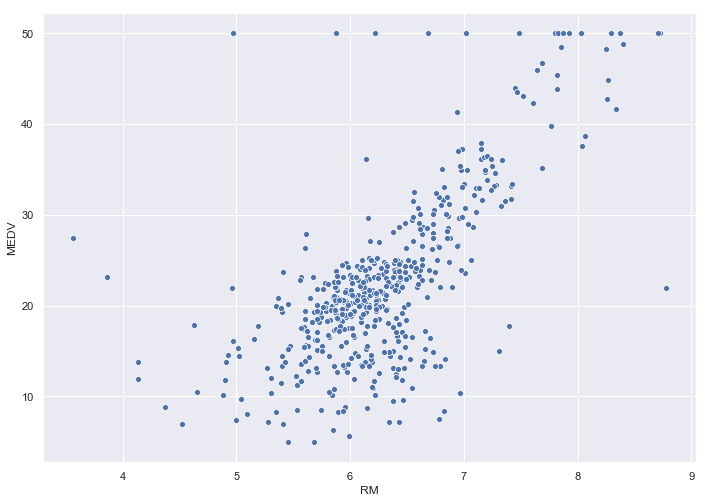

In [11]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

## Let's see if we can *fit a line* to this data.

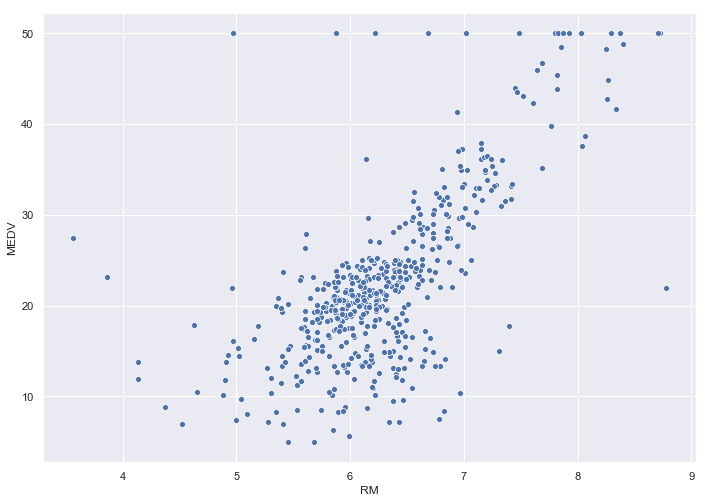

In [11]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

## So we want to find $a$ and $b$ such that $y = ax + b$ where $y$ is the price of the house and $b$ is the number of rooms.

# Big Idea
## We have a bunch of data points that sort of make a line.
## We want to find values for $a$ and $b$ in $y = ax + b$ that *fit* the data points.
## We define a criterion for how well a line fits the data.
## We look for a line that optimizes our criterion.
 - Using an optimization algorithm like gradient descent (note: better ways to optimize for linear regression)

## Let's define our criterion for the $a$ and $b$ that make $y = ax + b$ fit our data the best to be the squared error criterion.
### So we are going to take the difference between the predicted value and the actual value, square it, and call that our error. We want $a$ and $b$ such that the sum of these *errors* is as small as possible.

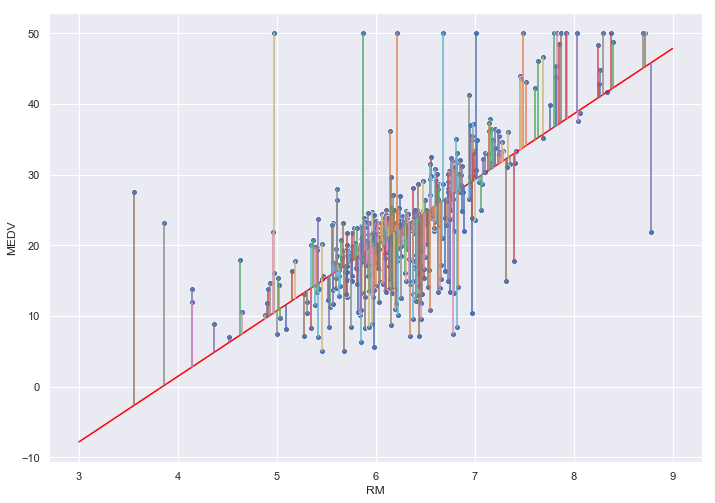

In [26]:
dataset = boston_df
ax = sns.scatterplot(x="RM", y="MEDV", data=dataset)
x = np.linspace(3, 9, 1000)
ax.plot(x, 9.274 * x - 35.64, color='red')

for row in dataset.itertuples():
    ax.plot([row.RM, row.RM], [row.MEDV, 9.274 * row.RM - 35.64])

## In this case $a \approx 9.3$ and $b \approx -35.6$. So we have
$$ \text{MEDV} = 9.3 * \text{RM} - 35.6 $$

In [97]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=666)

In [98]:
train['RM'].head()

343    6.696
342    6.540
458    6.301
376    6.649
302    6.495
Name: RM, dtype: float64

In [99]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [21]:
lin_model.coef_

array([9.27368249])

In [22]:
lin_model.intercept_

-35.640097347030476

In [34]:
X_test['MEDV'] = Y_test
X_test['prediction'] = X_test['RM'] * lin_model.coef_[0] + lin_model.intercept_

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
X_test.head()

,RM,MEDV,prediction
81,6.619,23.9,25.742407
453,7.393,17.8,32.920237
311,6.122,22.1,21.133387
291,7.148,37.3,30.648185
360,6.398,25.0,23.692923


In [36]:
X_test['diff_squared'] = (X_test['prediction'] - Y_test) ** 2

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
X_test.head()

,RM,MEDV,prediction,diff_squared
81,6.619,23.9,25.742407,3.394464
453,7.393,17.8,32.920237,228.621576
311,6.122,22.1,21.133387,0.934341
291,7.148,37.3,30.648185,44.246642
360,6.398,25.0,23.692923,1.708450


In [39]:
X_test.diff_squared.sum() / len(X_test)

42.76818033219253

In [41]:
preds_x_train = lin_model.predict(X_train)
mean_squared_error(preds_x_train, Y_train)

43.91464098533468

## So we sum this *dif_squared* column and divide by the number of entries to get our *Mean Squared Error* -- in this case it is about 42.77 (this is on our testing data).

## Overfitting
## We try to avoid this by splitting our data into a training set and a testing set.
![By Ghiles - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=47471056](Overfitted_Data.png)
            -By Ghiles - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=47471056

In [51]:
rooms_lstat_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['LSTAT'], boston_df['MEDV']], columns=['RM', 'LSTAT', 'MEDV'])
train, test = train_test_split(rooms_lstat_df, test_size = 0.25, random_state=666)
lin_model = LinearRegression()
lin_model.fit(np.c_[train['RM'], train['LSTAT']], train['MEDV'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## Now consider the same problem, except we know more about the housing market. 
## We add a column of data *LSTAT* that tells  us the percentage of the neighborhood that is *low income*.

In [47]:
rooms_lstat_df.head()

,RM,LSTAT,MEDV
0,6.575,4.98,24.0
1,6.421,9.14,21.6
2,7.185,4.03,34.7
3,6.998,2.94,33.4
4,7.147,5.33,36.2


In [44]:
rooms_lstat_df.head()

,RM,LSTAT,MEDV
0,6.575,4.98,24.0
1,6.421,9.14,21.6
2,7.185,4.03,34.7
3,6.998,2.94,33.4
4,7.147,5.33,36.2


## If LSTAT correlates with MEDV, a linear regression on this data should improve our Mean Squared Error.
## Again, we are trying to find a plane $$z = ax + by + c$$ or $$\text{MEDV} = w_1 * \text{RM} + w_2 * \text{LSTAT} + c$$ that minimizes our mean squared error.  

In [54]:
with_preds = test.drop(columns='MEDV')
with_preds['prediction'] =  lin_model.predict(with_preds)
with_preds['MEDV'] = test['MEDV']
with_preds['diff_squared'] = (with_preds['MEDV'] - with_preds['prediction']) ** 2
with_preds.head()

,RM,LSTAT,prediction,MEDV,diff_squared
81,6.619,7.22,27.861800,23.9,15.695861
453,7.393,16.74,26.251842,17.8,71.433626
311,6.122,5.98,25.901409,22.1,14.450713
291,7.148,3.56,33.008254,37.3,18.419088
360,6.398,7.79,26.301045,25.0,1.692718


## We now have a mean squared error of about 28 (it was about 43 when only using number of rooms.

## If we keep adding features, we can probably improve on this model...to a point. For example, if we add in the student to teacher ratio in the local schools we can improve our mean squared error to 26.6 (from 28 with only two features).

In [56]:
rooms_lstat_pt_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['LSTAT'], boston_df['PTRATIO']], columns=['RM', 'LSTAT', 'PTRATIO'])
Y = boston_df['MEDV']
X_train, X_test, Y_train, Y_test = train_test_split(rooms_lstat_pt_df, Y, test_size = 0.25, random_state=666)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
predictions = lin_model.predict(X_test)
mse = mean_squared_error(predictions, Y_test)
r2 = r2_score(predictions, Y_test)
# print("mse: {} -- r^2: {}".format(mse, r2))
display(rooms_lstat_pt_df.head(5))

,RM,LSTAT,PTRATIO
0,6.575,4.98,15.3
1,6.421,9.14,17.8
2,7.185,4.03,17.8
3,6.998,2.94,18.7
4,7.147,5.33,18.7


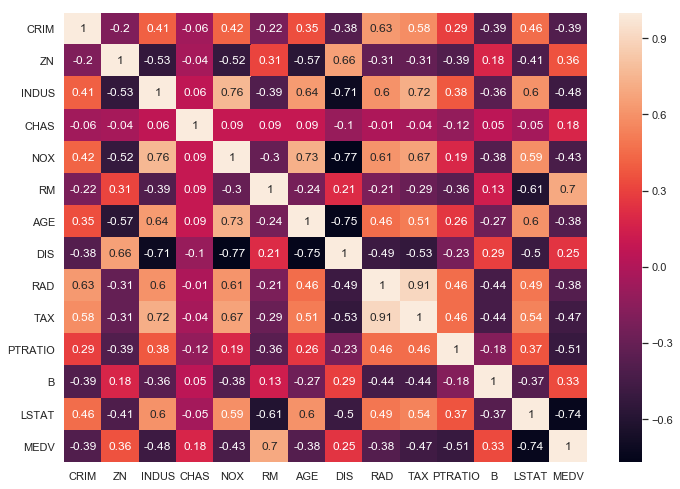

In [57]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_matrix = boston_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [32]:
X_test['MEDV'] = Y_test
test = X_test

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


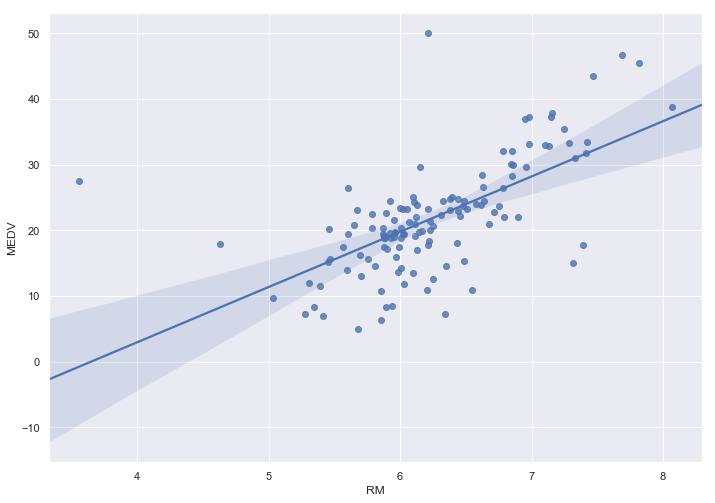

In [34]:
sns.regplot(x="RM", y="MEDV", data=test)

# Another Dataset
## Handwritten digits - can we correctly classify them?
## Much more data this time (70,000 examples)

In [59]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

<Figure size 432x288 with 0 Axes>

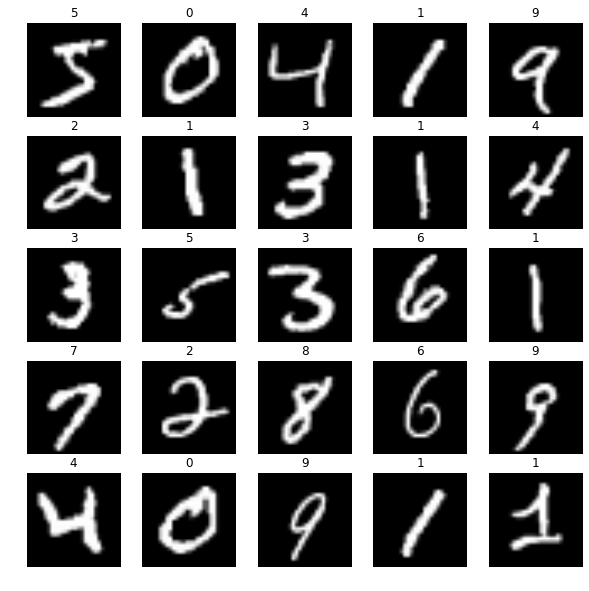

In [4]:
plt.subplots_adjust(hspace=1)
plt.figure(figsize=(10, 10))
for n in range(25):
    img = X_train[n]
    plt.subplot(5,5,n + 1)
    plt.title(Y_train[n])
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='bilinear')

## How can we do this? Is our data different than the Boston Housing data?
## What does this data look like?
- Each image is a 28 x 28 matrix of pixel values from 0 to 255

In [38]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

## We can take each 28 x 28 array and make it a 784 dim vector
## Now we have a problem much like the Boston Housing data problem -- we just have a 784 dimensional input.

In [39]:
np.reshape(X_train[0], 784)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

## The output, however, is quite different. In the Boston Housing problem we were predicting a single value, how can we do that here?
## Let's consider a simpler problem: Suppose we have the same dataset, but we are only concerned if the number is a 7 or not a 7.

## We input a 784 dim vector
## We want to output if the image is a 7 or not a 7

## We input a 784 dim vector
## We want to output if the image is a 7 or not a 7 - let's output a 1 if it is a 7 and a 0 if it isn't.

## If this were like our linear regression example we would be looking for coefficients $w_1, w_2, \ldots, w_{784}$ and $c$ such that $$w_1x_1 + w_2x_2 + \cdots + w_{784}x_{784} + c$$ *best fits* our data.

## We'd like our inputs that are 7s to output 1, and everything else to output 0. The linear combination $$w_1x_1 + w_2x_2 + \cdots + w_{784}x_{784} + c$$ could take on any real values, so let's restrict it.

## Consider the sigmoid function 
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

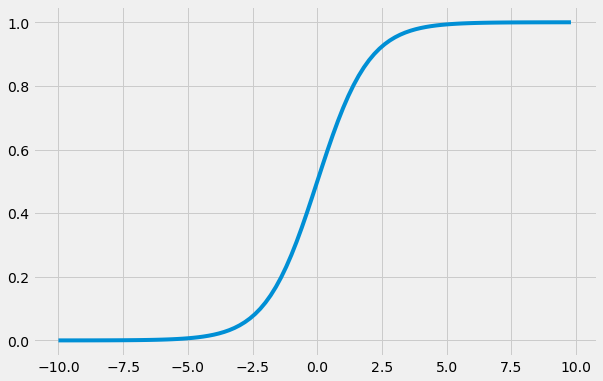

In [67]:
plt.figure(figsize=(9, 6))
plt.style.use('fivethirtyeight')
x = np.arange(-10, 10, 0.2)
plt.axis('on')
plt.plot(x, 1 / (1 + np.exp(-x)))

## This bounds our output between 0 and 1.

## In our linear regression example, we looked at squared error and minimized to find the coefficients that gave us the *best fit*.
## Could we do that here? What would that look like?

## Let $\hat{y}$ represent our output value, the thing we want to be one when we have a 7 or 0 when we don't. Let $y$ be the actual value of our training example.
## Using squared error we could define our loss function as
## $$\mathcal{L}(\hat{y}, y) = (y - \hat{y})^2 $$

## Using squared error we could define our loss function as
## $$\mathcal{L}(\hat{y}, y) = (y - \hat{y})^2 $$
## This turns out to make the optimization problem non-convex.
## Instead, consider
## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$

## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$
## When $y = 1$
## $$ \mathcal{L}(\hat{y}, 1) = - (1) \log(\hat{y}) = - \log(\hat{y}) $$

## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$
## When $y = 1$
## $$ \mathcal{L}(\hat{y}, 1) = - (1) \log(\hat{y}) = - \log(\hat{y}) $$
## Remember, we want to minimize this, so notice that $- \log(\hat{y})$ is minimized when $\hat{y}$ is large, but remember that $\hat{y}$ is bounded between 0 and 1, so the maximum value it can take on is 1. So our loss function wants our estimate to be as close to 1 as possible when our training example is a 7.

## $$ \mathcal{L}(\hat{y}, y) = - \left( y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right) $$
## Similarly, when $y = 0$
## $$ \mathcal{L}(\hat{y}, 0) = - \log(1 - \hat{y}) $$
## So our loss function wants our estimate, $\hat{y}$, to be 0 when our training example is not a 7. 

# Review
## We want to predict if an image is a 7 or not a 7.
## We convert the image from a 28 x 28 array to a 784 vector
## This vector is our input and we want our output to be a 1 if we have a 7 and a 0 if we don't
## The output is computed as follows
$$ z(x) = w_1x_1 + w_2x_2 + \cdots + w_{784}x_{784} + c $$
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
## $\sigma(z)$ is bounded between 0 and 1 and our loss function will help us get the *best values* for $w_1, w_2, \ldots, w_{784}, c $ through optimization.

In [63]:
Y_train_7 = Y_train == 7
Y_train_7 = Y_train_7.astype(int)

Y_test_7 = Y_test == 7
Y_test_7 = Y_test_7.astype(int)

In [66]:
Y_train[0:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

In [67]:
input_dim = 784 #28*28 
X_train_7 = X_train.reshape(60000, input_dim) 
X_test_7 = X_test.reshape(10000, input_dim) 
X_train_7 = X_train_7.astype('float32') 
X_test_7 = X_test_7.astype('float32') 
X_train_7 /= 255 
X_test_7 /= 255

In [68]:
model = Sequential() 
model.add(Dense(1, input_dim=784, activation='sigmoid')) 
batch_size = 64 
nb_epoch = 50

In [69]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(X_train_7, Y_train_7, batch_size=batch_size, epochs=nb_epoch,verbose=1, validation_data=(X_test_7, Y_test_7)) 
score = model.evaluate(X_test_7, Y_test_7, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1661 - acc: 0.9441 - val_loss: 0.1079 - val_acc: 0.9703
Epoch 2/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0939 - acc: 0.9743 - val_loss: 0.0873 - val_acc: 0.9774
Epoch 3/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0809 - acc: 0.9770 - val_loss: 0.0790 - val_acc: 0.9787
Epoch 4/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0746 - acc: 0.9782 - val_loss: 0.0744 - val_acc: 0.9795
Epoch 5/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0707 - acc: 0.9790 - val_loss: 0.0714 - val_acc: 0.9807
Epoch 6/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0680 - acc: 0.9798 - val_loss: 0.0693 - val_acc: 0.9814
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0660 - acc: 0.9806 - val_loss: 0.0678 - val_acc

In [70]:
predictions = model.predict(X_test_7)

<Figure size 842.4x595.44 with 0 Axes>

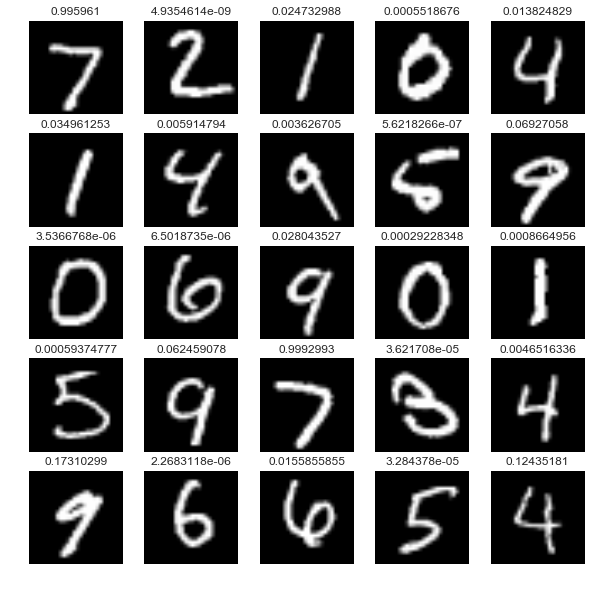

In [71]:
plt.subplots_adjust(hspace=1)
plt.figure(figsize=(10, 10))
for n in range(25):
    img = X_test[n]
    plt.subplot(5,5,n + 1)
    plt.title(predictions[n][0])
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='bilinear')

In [72]:
class_predictions = model.predict_classes(X_test_7)

In [73]:
wrong = np.where(class_predictions.flatten() != Y_test_7)

In [74]:
wrong[0].shape

(154,)

<Figure size 842.4x595.44 with 0 Axes>

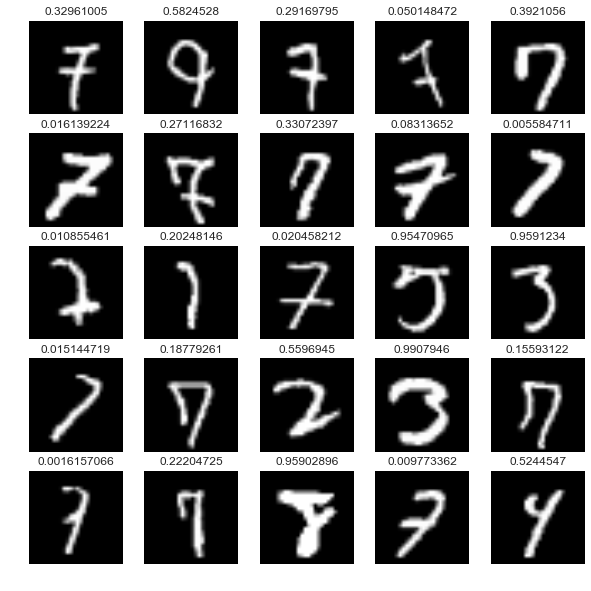

In [78]:
plt.subplots_adjust(hspace=1)
plt.figure(figsize=(10, 10))
for i, n in enumerate(wrong[0][25:50]):
    img = X_test[n]
    plt.subplot(5,5,i + 1)
    plt.title(predictions[n][0])
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='bilinear')

In [79]:
input_dim = 784 #28*28 
X_train_all = X_train.reshape(60000, input_dim) 
X_test_all = X_test.reshape(10000, input_dim) 
X_train_all = X_train_all.astype('float32') 
X_test_all = X_test_all.astype('float32') 
X_train_all /= 255 
X_test_all /= 255

In [81]:
Y_train_all = np_utils.to_categorical(Y_train, 10) 
Y_test_all = np_utils.to_categorical(Y_test, 10)

In [82]:
output_dim = nb_classes = 10 
all_model = Sequential() 
all_model.add(Dense(output_dim, input_dim=input_dim, activation='softmax')) 
batch_size = 64 
nb_epoch = 50

In [83]:
all_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 
history = all_model.fit(X_train_all, Y_train_all, batch_size=batch_size, epochs=nb_epoch,verbose=1, validation_data=(X_test_all, Y_test_all)) 
score = all_model.evaluate(X_test_all, Y_test_all, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 1.0146 - acc: 0.7556 - val_loss: 0.6090 - val_acc: 0.8617
Epoch 2/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.5600 - acc: 0.8608 - val_loss: 0.4809 - val_acc: 0.8808
Epoch 3/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.4775 - acc: 0.8756 - val_loss: 0.4298 - val_acc: 0.8892
Epoch 4/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.4374 - acc: 0.8829 - val_loss: 0.4010 - val_acc: 0.8953
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.4125 - acc: 0.8886 - val_loss: 0.3810 - val_acc: 0.8984
Epoch 6/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.3952 - acc: 0.8924 - val_loss: 0.3672 - val_acc: 0.9024
Epoch 7/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.3822 - acc: 0.8957 - val_loss: 0.3564 - val_acc

In [84]:
all_predictions = all_model.predict_classes(X_test_all)

<Figure size 842.4x595.44 with 0 Axes>

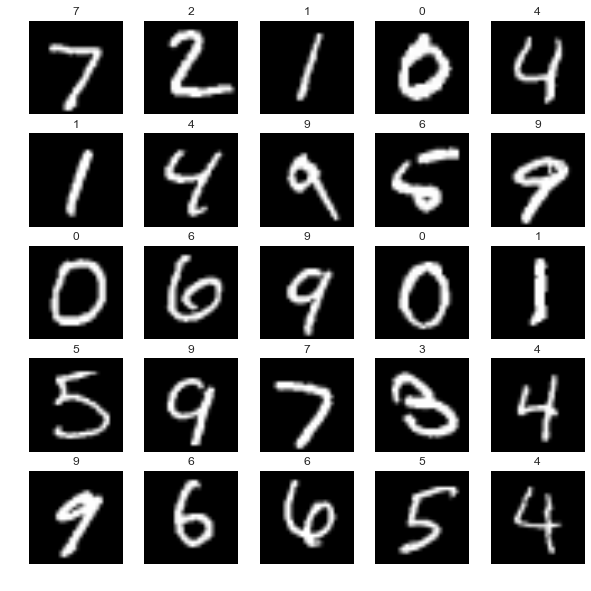

In [85]:
plt.subplots_adjust(hspace=1)
plt.figure(figsize=(10, 10))
for n in range(25):
    img = X_test[n]
    plt.subplot(5,5,n + 1)
    plt.title(all_predictions[n])
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='bilinear')

In [86]:
all_wrong = np.where(all_predictions.flatten() != Y_test)

In [87]:
all_wrong[0].shape

(789,)

<Figure size 842.4x595.44 with 0 Axes>

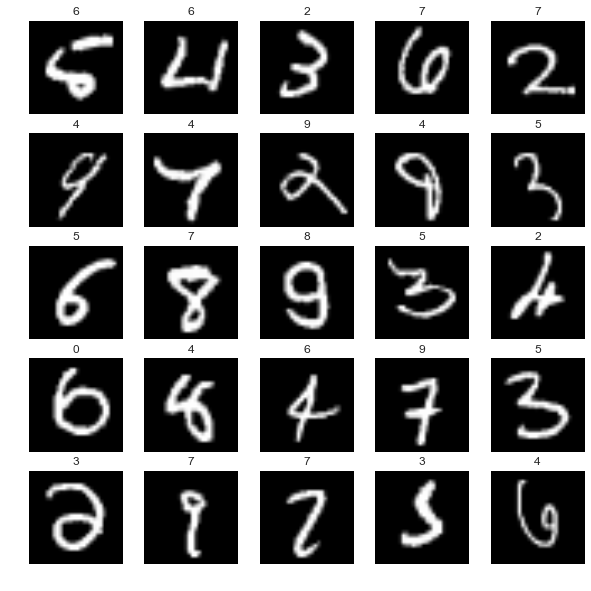

In [88]:
plt.subplots_adjust(hspace=1)
plt.figure(figsize=(10, 10))
for i, n in enumerate(all_wrong[0][:25]):
    img = X_test[n]
    plt.subplot(5,5,i + 1)
    plt.title(all_predictions[n])
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='bilinear')

In [89]:
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

X_train_cnn = X_train_cnn.astype('float32')
X_test_cnn = X_test_cnn.astype('float32')

X_train_cnn /= 255
X_test_cnn /= 255

In [90]:
cnn_model = Sequential()
cnn_model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
cnn_model.add(Dense(128, activation=tf.nn.relu))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(10,activation=tf.nn.softmax))

In [91]:
cnn_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
cnn_model.fit(x=X_train_cnn,y=Y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.2051 - acc: 0.9381
Epoch 2/10
60000/60000 [==============================] - 73s 1ms/step - loss: 0.0833 - acc: 0.9750
Epoch 3/10
60000/60000 [==============================] - 72s 1ms/step - loss: 0.0573 - acc: 0.9818
Epoch 4/10
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0453 - acc: 0.9855
Epoch 5/10
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0352 - acc: 0.9886
Epoch 6/10
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0287 - acc: 0.9906
Epoch 7/10
60000/60000 [==============================] - 69s 1ms/step - loss: 0.0248 - acc: 0.9919
Epoch 8/10
60000/60000 [==============================] - 70s 1ms/step - loss: 0.0199 - acc: 0.9933
Epoch 9/10
60000/60000 [==============================] - 71s 1ms/step - loss: 0.0219 - acc: 0.9926
Epoch 10/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.0180 - acc: 0.9940

In [94]:
cnn_predictions = cnn_model.predict(X_test_cnn)

In [96]:
cnn_predictions_class = cnn_model.predict_classes(X_test_cnn)

In [97]:
cnn_wrong = np.where(cnn_predictions_class.flatten() != Y_test)

In [100]:
cnn_wrong[0].shape

(166,)

<Figure size 432x288 with 0 Axes>

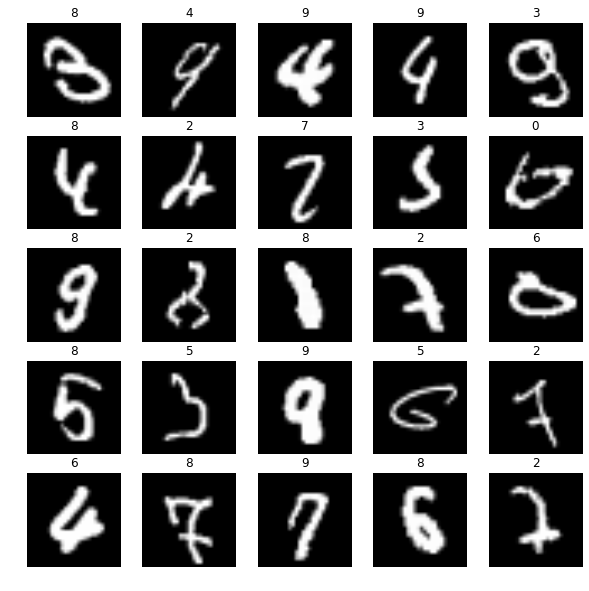

In [103]:
plt.subplots_adjust(hspace=1)
plt.figure(figsize=(10, 10))
for i, n in enumerate(cnn_wrong[0][:25]):
    img = X_test[n]
    plt.subplot(5,5,i + 1)
    plt.title(cnn_predictions_class[n])
    plt.axis('off')
    plt.imshow(img, cmap='gray', interpolation='bilinear')

In [6]:
textgen = textgenrnn.textgenrnn()
textgen.train_from_file('/Users/mmoran/Desktop/mmc2019/conf_book.txt', num_epochs=10)

290 texts collected.
Training on 96,491 character sequences.
Epoch 1/10
753/753 [==============================] - 376s 499ms/step - loss: 1.5621
####################
Temperature: 0.2
####################
110 TI-DISIES STATIONS THE AND CANNING STATE THE STUDENTS AND STAT AND STAT THE ALL STAR AND THE STAT AND AND CANCAL INSTREEDING THE AND THE AND THE STUDENTS THE STUDENTS THE THE CONDERSES STATE THE STAT STATE TO MATHEMATICS STATIONS STATING STATE TO MATHEMATICS STATIONS STATING THE STATE TO MATHEM

110 TI-NEW DISCESTING THE AND STAT THE STATE THE STATE STATE THE STUDENTS THE IN THE AND AND THE CONDERING STUDENTS STAT THE THE STATIONS FOR WHAT THE STATIONS THE WHAT THE STATIONS AND STATE THE WANDS STATING STATE TO MATHEMATICS STATIONS STATION THE AND THE AND STAT THE NOW IN THE AND STRATERACTI

110 MATHEMATICAL STATIONS STATIONS STATIONS STATIONS STATIONS STATIONS STARES STAR STATE TO MATHERECS STATIONS STAR STATING STUDENTS THE STATIONS STAR STATIONS STATIONS STARCICS STATIONS STATE 

753/753 [==============================] - 366s 486ms/step - loss: 1.1285
####################
Temperature: 0.2
####################
226 CODING STUDENTS IN THE STUDENTS TO MATH THE CONCESS STUDENTS IN MATH TO PROBLEM SOLVING Steve Marine Kater 6-12 In this workshop will be activities to develop the math concepts and provide the math class and strategies. We will discuss some of the math classrooms. We will discuss the concepts o

209 MATH TO PROBLEM TO DEVICS Steve Come Come the Conference of the Thinking and Steve Chansentent is the math concepts of the math concepts.

209 APPROACY TO BASED ON STRATEGO IN AP STUDENTS IN THE CONCESS STRATEGO TO PROBLEM SOLVING Steve Marine 6-12 This workshop will be successfully and support and concepts and concepts and engage your students in the concepts and the math computer to share the math concepts. We will discuss the probl

####################
Temperature: 0.5
####################
205 MATH THAT MODULCS MATH IN THE MATH MATHEMATICS TO DIFFENIZA

307 THE NEW STUDENTS IN THE UNDERSTANDING STUDENTS IN MATH MATHEMATICS Steve 6-12 We will get some students to engage your students who think about the problems that work their own original strategies. We will construct to the equitable activities that will engage your students and demonstration an

####################
Temperature: 0.5
####################
307 PROBLEMS Jack BROGING Kanggg & Derek & Research 6-12 We will share with and server students to demonstrate methods of incorporating their own classroom.

305 PROBLEM SOLVING George Marino & John Hangon 6-12 Board assess assessments will be minimalized for students and or the activities that be able to teach mathematics and the problems will be applied to meet the school problems that will be covered in math and equitable strategies. Come to explore 

305 COLOR STRUCTURES John Benty Viktora 9-12 Let’s be they do you guy the place? Students can be applied to engage your students to explore the serving is interested to computer the

229 THE WORD OF CAS AND CODING AND COMMONS THEIR DESMOS TO STATISTICS SENSES John Bendohlo & Karen Triea & SESS 10-12 In this workshop we will pose in Algebra the reasoning problems and can be able to engage students to construct the interrelated problems that have become multiplication and problem

308 SETION WITH THE COMMON FOR STUDENT STATUS Suggest Research, LEGN & STANDARDS THROUGH STUDENT THROUGH STUDENT GEOMETRY THROUGH MATH CONTERSTANDING MATH AND CODING AND YOUR STUDENTS IN THE UP OPTEP Bolgyn & Martin Marino 1-6

225 RETHINK! EXAM INVESTIGATION MATH MATHEMATICS FOR STUDENT AND SENSE AND COMPLE Kelly Kram & EMround K-Stenware in Common Core with a huntly play about the productive problems in math theorems and to be able to teach your classroom on the communication and relationship is for a look figure of the

####################
Temperature: 1.0
####################
307 STUDENTS THROUGH DAY GAMEBOID FOR Eri Shapun Kristent Huebilis SHOULEM STEM Scott K-8 Have you emphasize Ex

In [100]:
textgen = textgenrnn.textgenrnn()
textgen.train_from_file('/Users/mmoran/Desktop/mmc2019/conf_book.txt', num_epochs=10)

482 texts collected.
Training on 160,346 character sequences.
Epoch 1/10
1252/1252 [==============================] - 784s 626ms/step - loss: 1.5023
####################
Temperature: 0.2
####################
227 A CALCUATING AP AP AP AP AP AP ABLE CALCUUL A Standard AP Through the student answer to problem and students to include the student content their studentt and the content classroom of the studentt of the problem and a strategies of the problem for the The Come Advance A Common Common Problem an

227 A FUNCATICALLY I THE CALCICAL THE AP AP AP AP AP APPRING APPRING AP AP THE THE AP ABLE CALCUS AP A CALCUAL Standard Star WHA A CALCUAL THE THE STUDENT THE AND CALCUE ABLE ABLE ABLE SCANCE THE AND AP THE MATH AND CALCUALICAL THE CALCUES ALGEBRA Star WHA AP THE A PROBLE ASSES AP AP AP ASSES ASSES

227 THE A THE AP APPRITATION AB AP ABLE ABLE STUDENT ABOUT THE AP THE AND ALL AP AP AP AP AP ALGEBRA Star WHIT ALL STUDENT STUDENT ASSES AP AP AP AP THE AND A PROBLE GETICAL STUDENT TALK AP 

126 WROUGH FISSING IN MATH: THE TEACHING MY ALGEBRA!! WHEY THE WEARISH TE IT! MOREE! Devalory, Rynoli 6-12 The introduction tosk and material posies that projects and magical ways.

Epoch 4/10
1252/1252 [==============================] - 671s 536ms/step - loss: 1.1283
####################
Temperature: 0.2
####################
210 THE COMMON FOR THE MATHEMATICS AND STRUCTION FOR THE COMMON CORE DO THE MATH TO DEVELOPING MATH STUDENTS SOLVING STUDENTS FOR THE COMMON CORE STUDENTS SOCIAL TO DEVELOPING STUDENTS STUDENTS TO COMMON COMMON CORE STUDENT STRUCTION STUDENTS AND STRUCTION STUDENTS John Benn Core Carroll 7-12 We wi

201 MATH CLASS Carrie Starrs & Julie Hardin K-5 This workshop will be asked for all levels of the problem of the problem of the problem of the connection of the first problem of the problem with a standards and mathematical strategies to engage and use the connection of the problem of the problem o

211 MATH TO COMMON FOR THE COMMON FOR THE COMMON STRATEGIES Carroll Co

1252/1252 [==============================] - 603s 481ms/step - loss: 0.9505
####################
Temperature: 0.2
####################
113 CODING THINKING THE CALCULUS Steve Viktora 9-12 This session will explore and share the problem to discuss the problem of the mathematics to engage your students to engage your students to engage your students to discuss the problems and teaching the problems and the session will be shared to e

118 THE TI-NSPIRE THIS A FOR PROBLEM CALCULUS Steve Viktora 9-12 This session will explore the problem on workshop will be shared to the sequence of the problems and make connections to engage your students and students to engage your students and students to engage your students and students to ex

118 THE TI-NSPIRE THINKING THE STUDENTS Steven Core Spangler 7-12 This session will explore the problems and teachers will explore the communication of the number of the common content of the problems and then work the ready of the mathematics to engage your stud

125 THE MATH CLASSROOM STATS OF DESMOS – THE SOLVING STUDENTS Scott Nemecek 9-12 The problem of the unit can be used to engage your students and seem to develop the concepts of the compass of problems and activities to do to planne their mindsets and the concepts of the problem of the powerful stra

####################
Temperature: 0.5
####################
304 MATH COMMON FOR PROBLEMS AND STATISTICS IN A CONCEPTIES WITH MATH TEACHING AND SOLVING TEACHING CLASSROOM Annie Forest 9-12 There is a student word aspects of the route of mathematics with the problem and thinking about all learned back to all learners.

321 MATH TO DESMOS FOR ALGEBRA AND “REALLY Scott Kelly Mathematical SpeakerHets the Common Core Standards and Probability to the complete conceptual applications of the standards of all of the Common Core Standards, and the new team and connect of the process in the content activities that include 

314 MATH TEACHING AND HANDS-ON Martin Funk 9-12 Will be minimal triangle and stu